In [1]:
%load_ext autoreload


In [2]:
%autoreload
from ceruleanml.multispectral_blocks import open_n_channel_img, open_mask_from_record, MSTensorImage, MSTensorMask, TensorImageResizer
from fastai.data.block import TransformBlock
from functools import partial
from fastai.vision.core import AddMaskCodes
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.learner import unet_learner
from fastai.data.transforms import IndexSplitter, Normalize
from fastai.metrics import DiceMulti, Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os, random
from icevision.visualize import show_data
import torch
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from fastai.vision.core import PILImageBW
from fastai.losses import DiceLoss


### Parsing COCO Dataset with Icevision

In [3]:
with_context=False
mount_path = "/root/"
train_set = "train-no-context-512"
tiled_images_folder_train = "tiled_images_no_context"
json_name_train = "instances_TiledCeruleanDatasetV2NoContextFiles.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-no-context-512"
tiled_images_folder_val= "tiled_images_no_context"
json_name_val = "instances_TiledCeruleanDatasetV2NoContextFiles.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

#with aux files
# with_context=True
# mount_path = "/root/"
# train_set = "train-with-context-512"
# tiled_images_folder_train = "tiled_images"
# json_name_train = "instances_TiledCeruleanDatasetV2.json"

# coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
# tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
# val_set = "val-with-context-512"
# tiled_images_folder_val= "tiled_images"
# json_name_val = "instances_TiledCeruleanDatasetV2.json"
# coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
# tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
negative_sample_count = 0
negative_sample_count_val = 40
area_thresh = 10
# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

In [4]:
# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df.groupby("label").count()

In [5]:
record_collection_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=True
)
record_ids_train = record_collection_to_record_ids(record_collection_train)

  0%|          | 0/3863 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 3014/3014 [00:00<00:00, 112003.69it/s]


0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


0it [00:00, ?it/s]

In [6]:
record_collection_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=True
)
record_ids_val = record_collection_to_record_ids(record_collection_val)

  0%|          | 0/352 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 266/266 [00:00<00:00, 102300.10it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

In [8]:
train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_train + record_collection_val

def get_val_indices(combined_ids, val_ids):
    return list(range(len(combined_ids)))[-len(val_ids):]

val_indices = get_val_indices(train_val_record_ids, record_ids_val)

In [9]:
#show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser and applies transformations

In [10]:
size = 512  # Progressive resizing could happen here
def get_image_by_record_id(record_id):
    return get_image_path(combined_record_collection, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(combined_record_collection, record_id)

def create_data_block(size, with_context=True):
    imblock = ImageBlock if with_context else ImageBlock(cls=PILImageBW)
        
    coco_seg_dblock = DataBlock(
            blocks=(imblock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
            get_x=get_image_by_record_id,
            splitter=IndexSplitter(val_indices),
            get_y=get_mask_by_record_id,# *aug_transforms(),  # we need to normalize here or else fastai incorrectly normalizes by the pretrained stats
            item_tfms=Resize(size),
            n_inp=1
        )
    return coco_seg_dblock
coco_seg_dblock = create_data_block(size, with_context=with_context)
dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=6)

In [11]:
db_custom = DataBlock(blocks=(TransformBlock(type_tfms=partial(MSTensorImage.create, chnls=[0], record_collection=combined_record_collection)),
                       TransformBlock(type_tfms=partial(MSTensorMask.create, record_collection=combined_record_collection), 
                                      item_tfms=AddMaskCodes(codes=class_ints)),
                      ),
               get_items=record_collection_to_record_ids,
               splitter=IndexSplitter(val_indices),
               n_inp=1,
               item_tfms= TensorImageResizer(size)
              )

dls_custom = db_custom.dataloaders(source=combined_record_collection, bs=6)

## Inspecting why Fastai DataBlock converts single channel to 3 channel

In [12]:
original_x,original_y = dls.one_batch()

In [13]:
b = dls_custom.one_batch()

In [14]:
print(original_x.shape,original_y.shape)

torch.Size([6, 1, 512, 512]) torch.Size([6, 512, 512])


In [15]:
custom_x,custom_y = dls_custom.one_batch()
print(custom_x.shape,custom_y.shape)

torch.Size([6, 1, 512, 512]) torch.Size([6, 512, 512])


In [16]:
MSTensorImage.create(94, chnls=[0], record_collection=combined_record_collection)

MSTensorImage: torch.Size([1, 512, 512])

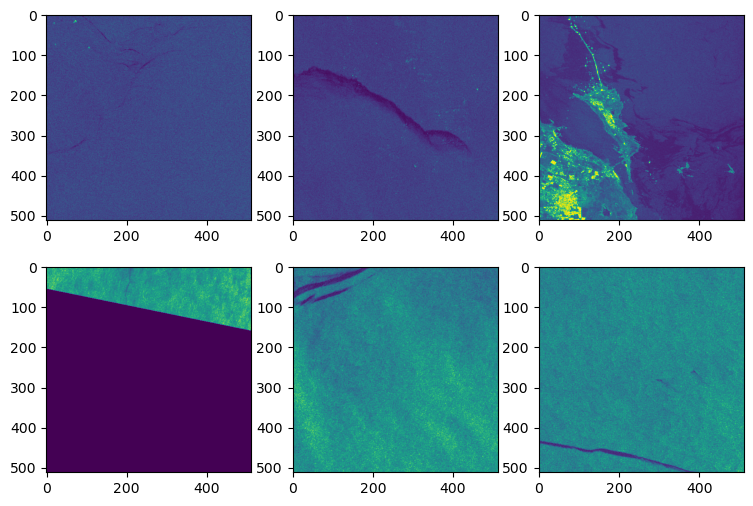

In [17]:
dls_custom.show_batch(b=b,chnls=[0], show_label=False)

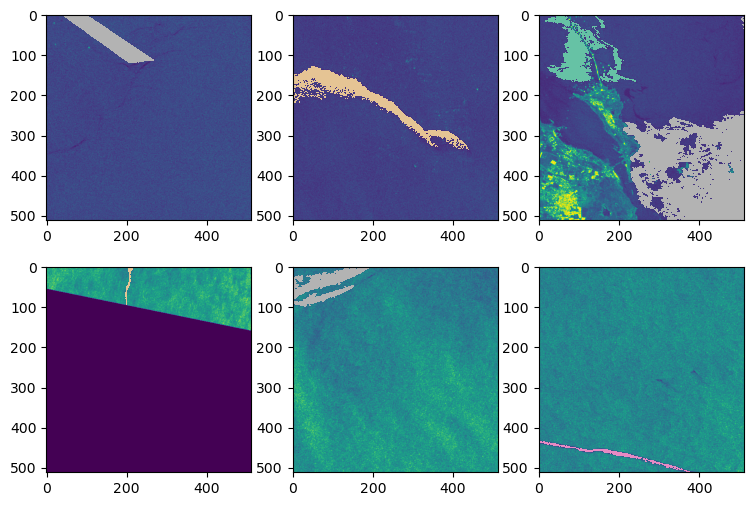

In [18]:
dls_custom.show_batch(b=b,chnls=[0], show_label=True)

In [19]:
import numpy as np
for i in range(b[1].shape[0]):
    print(np.unique(b[1][i].cpu().detach().numpy()))

[          0           6]
[          0           5]
[          0           1           6]
[          0           5]
[          0           6]
[          0           3]


https://docs.fast.ai/tutorial.siamese.html

https://towardsdatascience.com/how-to-create-a-datablock-for-multispectral-satellite-image-segmentation-with-the-fastai-v2-bc5e82f4eb5

### Fastai2 Trainer

In [24]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)
print(experiment_dir)

arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

# removed these callbacks since they cause this error: https://forums.fast.ai/t/learner-object-has-no-attribute-recorder/46328/18
# or no model.pth found in experiment folder for some reason 
cbs = [#SaveModelCallback(monitor="valid_loss", with_opt=True), 
        # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=5), 
        #TensorBoardCallback(projector=False, trace_model=False)
]

/root/experiments/cv2/08_Jun_2022_20_39_54_fastai_unet


In [21]:
db_custom = DataBlock(blocks=(TransformBlock(type_tfms=partial(MSTensorImage.create, chnls=[0], record_collection=combined_record_collection)),
                       TransformBlock(type_tfms=partial(MSTensorMask.create, record_collection=combined_record_collection), 
                                      item_tfms=AddMaskCodes(codes=class_ints)),
                      ),
               get_items=record_collection_to_record_ids,
               splitter=IndexSplitter(val_indices),
               n_inp=1,
               item_tfms=TensorImageResizer(size)
              )

dls_custom = db_custom.dataloaders(source=combined_record_collection, bs=6)

In [22]:
dls_custom.one_batch()[0].shape

torch.Size([6, 1, 512, 512])

In [23]:
dls.one_batch()[0].shape

torch.Size([6, 1, 512, 512])

In [41]:
# # learner.recorder.metric_names
# def create_learner(dls,with_context=True):
#     if with_context:
#         learner = unet_learner(dls, archs[arch], metrics=[DiceMulti()], 
#                                model_dir=experiment_dir, n_in=3, n_out = 7, 
#                                cbs=cbs, loss_func=DiceLoss()) #cbs=cbs# SaveModelCallback saves model when there is improvement
#     else:
#         learner = unet_learner(dls, archs[arch], metrics=[DiceMulti()], 
#                                model_dir=experiment_dir, n_in=1, n_out = 7, 
#                                cbs=cbs, loss_func=DiceLoss()) #cbs=cbs# SaveModelCallback saves model when there is improvement
#     print(f"Running model with _context set to: {with_context}")
#     return learner
# learner = create_learner(dls_custom, with_context=with_context)
# # lr = learner.lr_find()

In [ ]:
# from fastai.vision.learner import create_unet_model

# from fastai.vision.models.unet import DynamicUnet

# DynamicUnet??

# create_unet_model??

In [25]:
learner = unet_learner(dls_custom, archs[arch], metrics=[DiceMulti()], 
                       model_dir=experiment_dir, n_in=1, 
                       cbs=cbs, loss_func=DiceLoss(), normalize=False) #cbs=cbs# SaveModelCallback saves model when there is improvement

dice_multi changes a little bit when training with fewer samples. but not with more samples???

epoch,train_loss,valid_loss,dice_multi,time
0,14.930537,14.775812,0.165613,04:46


IndexError: index 3 is out of bounds for dimension 0 with size 1

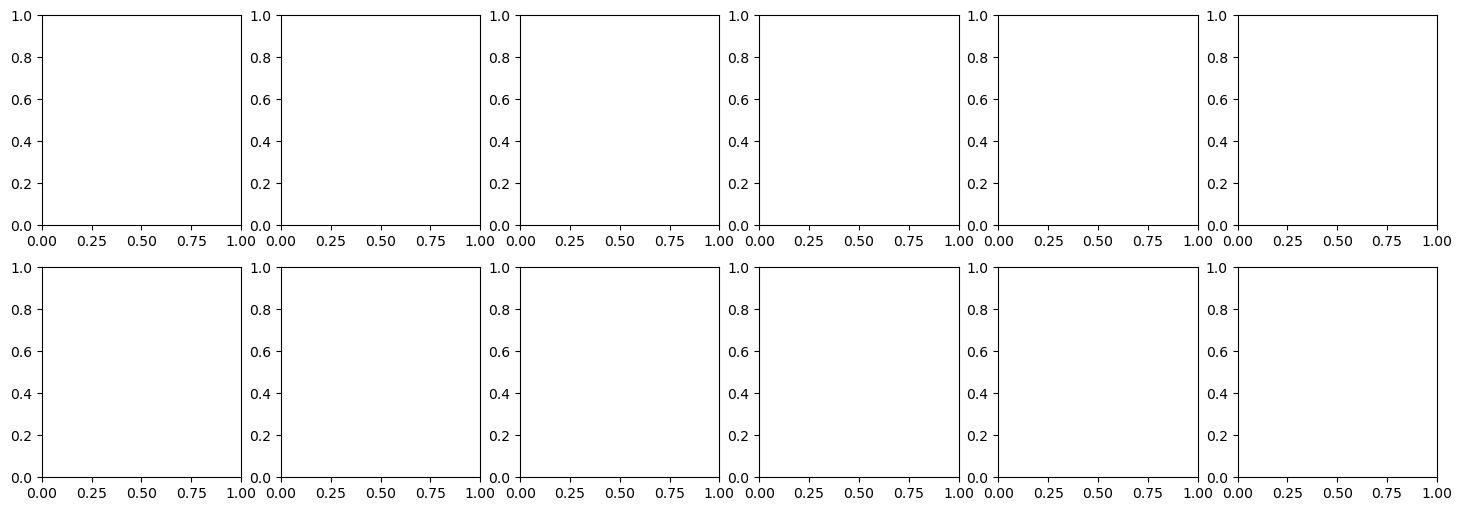

In [26]:
learner.fine_tune(25, 1e-4, freeze_epochs=1) # cbs=cbs

In [ ]:
!tensorboard --logdir="./runs"

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
# validation = learner.validate()  
# there's a strange bug here where an internal method is not found that should be found 
# for the Callback class. seems like a verison mismatch issue. happens if any callback included

In [ ]:
size=512
# savename = f'test_6batch_{arch}_{size}_{round(validation[1],3)}.pt'
savename = f'test_6batch_{arch}_{size}.pt'

We save the best model in a variety of formats for loading later

In [ ]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir)

../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/tracing_gpu_test_6batch_18_512.pt
../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/tracing_cpu_test_6batch_18_512.pt
../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/state_dict_test_6batch_18_512.pt


In [ ]:
#import pdb
#learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)


# Model Inference and Result Evaluation

import skimage.io as skio
import numpy as np
val_record_ids = record_collection_to_record_ids(record_collection_val)
pred_arrs = []
val_arrs = []
for v, i in zip(range(len(record_ids_val[0:10])), record_ids_val[0:10]):
    v = record_collection_val[v]
    v_masks = v.detection.masks[0].to_mask(v.common.height,v.common.width).data
    p = get_image_path(record_collection_val,i)
    arr = skio.imread(p)
    # necessary for 1 channel input since fastai uses PIL during predict
    class_pred = learner.predict(np.squeeze(arr))
    class_pred = class_pred[0].cpu().detach().numpy()
    pred_arrs.append(class_pred)
    val_arrs.append(v_masks)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/metrics.py:370: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


In [ ]:
data.class_mapping_coco

{'Infrastructure': 1,
 'Natural Seep': 2,
 'Coincident Vessel': 3,
 'Recent Vessel': 4,
 'Old Vessel': 5,
 'Ambiguous': 6,
 'Hard Negatives': 0}

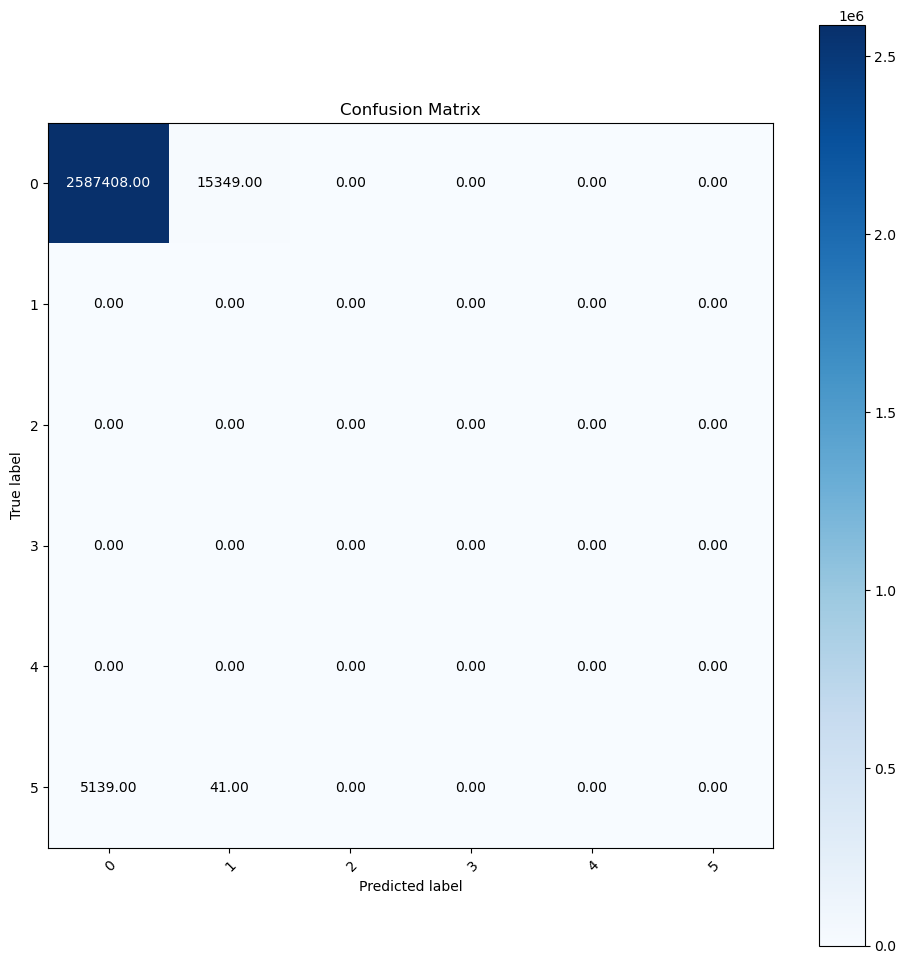

In [ ]:
cm, f1 = evaluation.cm_f1(val_arrs, pred_arrs, 6, mount_path)

In [ ]:
learner = torch.load("/root/data/experiments/cv2/10_May_2022_18_02_59_fastai_unet/18_64_0.493.pkl")


import skimage.io as skio
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
with learner.no_logging():
    for i in val_record_ids:
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learner.predict(arr)
        pred_arrs.append(pred_arr)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats